In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing
import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

# load results from a directory

In [3]:
pid_a = '07665771801545027002'
pid_s = '24656068102223723425'

# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')
                 and (pid_a in fname or pid_s in fname)]) + \
         sorted([oj(out_dir2, fname) for fname in os.listdir(out_dir2) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')
                 and (pid_a in fname or pid_s in fname)])    
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx') and (pid_a in fname or pid_s in fname)]
results = pd.concat(results_list, axis=1).T.infer_objects()
print(results.shape)

100%|██████████| 2/2 [00:00<00:00, 19.16it/s]

(2, 54)


**add cols**

In [4]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
# print('before', results.shape)
its, ts, results = process_results(results)
print('after', results.shape)

after (2, 84)


# pick examples

In [5]:
pre_a = '24421'
pre_s = '40043'

r = results
for pid in r.pid:
    if pid.startswith(pre_a):
        print('a', pid)
    if pid.startswith(pre_s):
        print('s', pid)

# good for 128
# pid_a = '24421020350011741116'
# pid_s = '40043048138378577087'

# good for 512
pid_a = '07665771801545027002'
pid_s = '24656068102223723425'

In [6]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) \
                 if (pid_a in fname or pid_s in fname)]) + \
         sorted([oj(out_dir2, fname) for fname in os.listdir(out_dir2) \
                 if (pid_a in fname or pid_s in fname)])

# weights
fnames_w = [fname for fname in fnames if 'weights' in fname]
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_w]
rw = pd.concat(results_list, axis=1).T.infer_objects()

# normal results
fnames_acc = [fname for fname in fnames if '/pid' in fname] # normal results
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_acc]
r = pd.concat(results_list, axis=1).T.infer_objects()
its, ts, r = process_results(r)

# get individual weights
rw_sgd = rw[rw.optimizer == 'sgd'].reset_index().iloc[0]
rw_adam = rw[rw.optimizer == 'adam'].reset_index().iloc[0]

# get accs
r_sgd = r[r.optimizer == 'sgd'].reset_index().iloc[0]
r_adam = r[r.optimizer == 'adam'].reset_index().iloc[0]

In [10]:
epoch = int(max(ts))
print(r_sgd.max_test_acc, r_adam.max_test_acc, r_sgd.max_train_acc, r_adam.max_train_acc)
print('sgd', r_sgd.accs_train[its == epoch], r_sgd.accs_test[its == epoch])
print('adam', r_adam.accs_train[its == epoch], r_adam.accs_test[its == epoch])

0.9706 0.9704 0.9999333333333333 0.9996833333333334
sgd [0.9999] [0.9692]
adam [0.99951667] [0.9679]


# remake weight plots with hist

In [ ]:
from matplotlib.ticker import NullLocator

def get_w(run):
    run['num_layer'] = int(run['num_layers'])
    run['hidden_size'] = int(run['hidden_size'])
    lay = 'fc.0.weight'

    # keys are epochs, vals are dicts of all weights
    weights_dict_dict = run['weights']

    # keys are layers, vals are weight values
#     print(weights_dict_dict.keys())
    weights_dict = weights_dict_dict[epoch]
#     print(weights_dict.keys())
    w = weights_dict[lay]

    return w

for run in [rw_sgd, rw_adam]:
    w = get_w(run)
    # matrix of weights (output x input)
    viz_weights.plot_weights(w, dset='mnist', C=18, dpi=120)
                
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.margins(0, 0)

*sort the weights by highest mem to lowest mem*

In [ ]:
for r_opt, run in zip([r_sgd, r_adam], [rw_sgd, rw_adam]):
    max_corrs = r_opt['mean_max_corrs'][epoch]['fc.0.weight']['max_corrs']
    w = get_w(run)
    inds = max_corrs.argsort()
    max_corrs = max_corrs[inds[::-1]]
    w = w[inds[::-1]]
    viz_weights.plot_weights(w, dset='mnist', C=18, dpi=120)
    
    plt.savefig(run.optimizer + '_sorted_' + str(run.hidden_size) + '_' + 'w0.pdf', 
            bbox_inches = 'tight', pad_inches = 0)

# make alterations

In [13]:
# all info in [r_sgd, r_adam], [rw_sgd, rw_adam]
def calc_accs(model, X_train, Y_train, X_test, Y_test):
    preds = model(X_train).data.cpu().numpy().argmax(axis=1)
    accs_train = preds==Y_train
    preds = model(X_test).data.cpu().numpy().argmax(axis=1)
    accs_test = preds==Y_test
    print('mean acc', np.mean(accs_train), np.mean(accs_test))
    return np.mean(accs_train), np.mean(accs_test)

def add_noise(X_train, X_test, val):
    return X_train + torch.empty(X_train.shape).uniform_(-val, val).cuda(), X_test + torch.empty(X_test.shape).uniform_(-val, val).cuda() 


# load model
# accs = pkl.load(open('accs_corrupted.pkl', "rb"))
# CONTRAST is actually random pixel noise
accs_train = {'rotate': [], 'noise': [], 'brightness': []}
accs_test = {'rotate': [], 'noise': [], 'brightness': []}
accs = {'sgd': {'train': deepcopy(accs_train), 'test': deepcopy(accs_test)},
        'adam': {'train': deepcopy(accs_train), 'test': deepcopy(accs_test)}}
rots = 180 * np.array([0.0025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4])
brights = 255 * np.array([0.0025, 0.05, 0.1, 0.2, 0.3, 0.4])
vals = 255 * np.array([0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4])
preds = []

# get data
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])
run['batch_size'] = int(run.batch_size)
train_loader, test_loader = data.get_data_loaders(run)
X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)

for run in [rw_sgd, rw_adam]:
    print(run.optimizer)
    
    
    # load in weights
    model = data.get_model(run)
    weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
    weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    
    weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
    model.load_state_dict(weights_dict_tensors)
    model = model.cuda()
    
    
    preds.append(model(X_test))
    
    # calc changed accs
    '''
    run['noise_rotate'] = 0 # degrees able to rotate
    run['noise_brightness'] = 0 # how much brightness can be jittered
    for val in vals:
        X_train1, X_test1 = add_noise(X_train, X_test, val)
        acc_train, acc_test = calc_accs(model, X_train1, Y_train, X_test1, Y_test)    
        accs[run.optimizer]['train']['noise'].append(acc_train)
        accs[run.optimizer]['test']['noise'].append(acc_test)   
        
    for rot in rots:
        run['noise_rotate'] = rot
        train_loader, test_loader = data.get_data_loaders(run)
        X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)
        acc_train, acc_test = calc_accs(model, X_train, Y_train, X_test, Y_test)    
        accs[run.optimizer]['train']['rotate'].append(acc_train)
        accs[run.optimizer]['test']['rotate'].append(acc_test)
    run['noise_rotate'] = 0 # degrees able to rotate
    
    for bright in brights:
        run['noise_brightness'] = bright
        train_loader, test_loader = data.get_data_loaders(run)
        X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)
        acc_train, acc_test = calc_accs(model, X_train, Y_train, X_test, Y_test)    
        accs[run.optimizer]['train']['brightness'].append(acc_train)
        accs[run.optimizer]['test']['brightness'].append(acc_test)   
    run['noise_brightness'] = 0
    '''

    
# pkl.dump(accs, open('accs_corrupted.pkl', 'wb'))

sgd
adam


# prediction-level plots

In [14]:
lay = torch.nn.Softmax(dim=1)
# lay(preds[0])
# def lay(x): return x

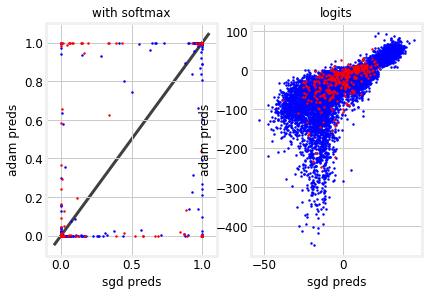

In [30]:
ps = lay(preds[0]).cpu().detach().numpy()
pa = lay(preds[1]).cpu().detach().numpy()

class_num = 4
fig, axes = plt.subplots(1, 2)

idxs_correct = (np.argmax(ps, axis=1) == Y_test)
ax = axes[0]
ax.plot(ps[:, class_num][idxs_correct], pa[:, class_num][idxs_correct], '.', color='blue', markersize=5) #, alpha=0.01)
ax.plot(ps[:, class_num][~idxs_correct], pa[:, class_num][~idxs_correct], '.', color='red', markersize=5) #, alpha=0.1)
ax.set_xlabel('sgd preds')
ax.set_ylabel('adam preds')
ax.set_title('with softmax')         
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0) 

ps = preds[0].cpu().detach().numpy()
pa = preds[1].cpu().detach().numpy()
ax = axes[1]
ax.plot(ps[:, class_num][idxs_correct], pa[:, class_num][idxs_correct], '.', color='blue', markersize=5) #, alpha=0.01)
ax.plot(ps[:, class_num][~idxs_correct], pa[:, class_num][~idxs_correct], '.', color='red', markersize=5) #, alpha=0.1)
ax.set_xlabel('sgd preds')
ax.set_ylabel('adam preds')
ax.set_title('logits')         
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)  

# plt.subplot(122)
plt.show()

In [ ]:
plt.figure(facecolor='w')
plt.plot(rots / 180, accs['sgd']['test']['rotate'], label='SGD rotate', alpha=0.5)
plt.plot(rots / 180, accs['adam']['test']['rotate'], '--', label='ADAM rotate', alpha=0.5)
plt.plot(brights / 255, accs['sgd']['test']['brightness'], label='SGD brightness', alpha=0.5)
plt.plot(brights / 255, accs['adam']['test']['brightness'], '--', label='ADAM brightness', alpha=0.5)
plt.plot(vals / 255, accs['sgd']['test']['noise'], label='SGD gaussian pixels', alpha=0.5)
plt.plot(vals / 255, accs['adam']['test']['noise'], '--', label='ADAM gaussian pixels', alpha=0.5)
# plt.xlim((0, 0.3))
# plt.xlim((0, 0.02))
plt.xlabel('Fraction corruption')
plt.ylabel('Test accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('corrupted.pdf')
plt.show()

# unrelated: check if bigger norm -> bigger mem

In [ ]:
r = results
r = r[r.corr0_final > 0.5]
r = r[r.max_test_acc >= 0.9]
r = r.reset_index()
row = r.iloc[7]
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed
print(row[sweep_params])
print('test acc', row.max_test_acc)
tmax = max(ts)
d = row['mean_max_corrs'][tmax]['fc.0.weight']
plt.plot(d['W_norms'], d['max_corrs'], 'o')
plt.xlabel('w_norm')
plt.ylabel('max corr')

print('unadj', row.corr0_final, 'adj', row.corr0_adj_final)
plt.show()